# MODELING 

Preferred clustering algorithms to be tested:
- KMeans Clustering
- Agglomerative Clustering
- DBSCAN

## 1 Modeling Prerequisites

### 1.1 Import Libraries

In [1]:
# !pip install hyperopt
# !pip install squarify
# !pip install joblib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
import logging
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
import time
import os
import joblib

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from matplotlib import colormaps
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from hyperopt import hp, tpe, rand, space_eval, fmin, Trials, STATUS_OK

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Define standard logging configuration
logging.basicConfig(
    level=logging.INFO,
    filename='../logs/onlineretail.log')

### 1.2 Load Files

In [3]:
try:
    df = pd.read_csv('../data/processed/online_retail_unscaled.csv', index_col=['CustomerID', 'LastPurchaseDate'])
    df_scaled = pd.read_csv('../data/processed/online_retail_scaled.csv', index_col=['CustomerID', 'LastPurchaseDate'])
    df_m_outliers = pd.read_csv('../data/processed/online_retail_m_outliers.csv')
    df_f_outliers = pd.read_csv('../data/processed/online_retail_f_outliers.csv')
    
except OSError as e:
    logging.error(e)

### 1.3 Random Seed

In [4]:
random_seed = 33

np.random.seed(random_seed)
np.random.default_rng(random_seed)
np.random.RandomState(random_seed)

RandomState(MT19937) at 0x7FCDE999EE40

## 2 Hyperparameter Tuning

DBSCAN Pre-requisites:

To determine the parameters for DBSCAN, it's essential to determine the two hyperparameters in DBSCAN (MinPts and 𝜀𝜀 ) that need to be optimized to yield good clustering results.\
Finding a good combination of MinPts and 𝜀𝜀 can be problematic if the density differences in the dataset are relatively large. \
A general rule of thumb is to set MinPts >= D+1, where D is the number of dimensions in the dataset. For most cases, a minimum value of MinPts = 3 is recommended.\
Create a k-distance graph to serve as a guide in selecting the appropriate epsilon value.\
Steps:
1. Calculate the distance to the k-th nearest neighbor for each point.
2. Sort and plot the distance and use the elbow method to choose the epsilon. 

Specific to the hyperparameter optimization, a range of values near the elbow point in the K-distance graph will be used.

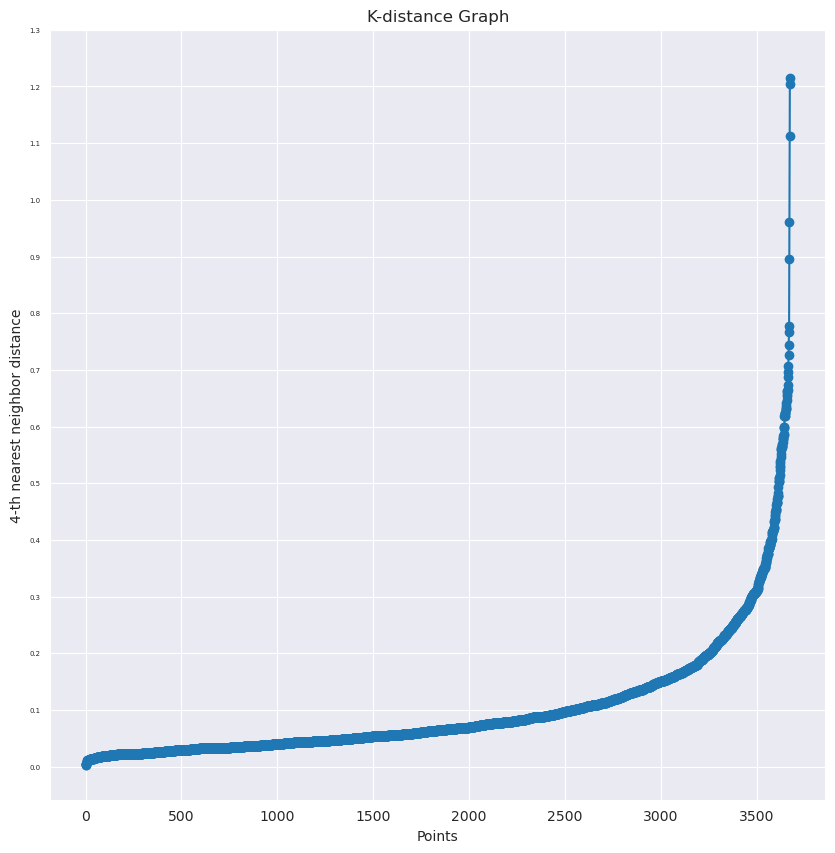

In [5]:
test_k = 4
X_scaled = df_scaled.to_numpy()

# Use NN to determine distances
mdl_nn = NearestNeighbors(n_neighbors=test_k)
mdl_nn.fit(X_scaled)

distances, indices = mdl_nn.kneighbors(X_scaled)
distances = np.sort(distances[:, test_k-1])

# Plot and choose the elbow point
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
plt.plot(distances, '-o')

plt.xlabel('Points')
plt.ylabel(f'{test_k}-th nearest neighbor distance')
plt.yticks(np.arange(0, max(distances)+0.1, 0.1), fontsize=5)
plt.title('K-distance Graph')
plt.show()

<div class="alert alert-block alert-success">
The estimated elbow point on the K-distance graph is between <b>0.1 - 0.2</b>. This range will be used for the DBSCAN hyperparameter tuning.</div>

In [6]:
X = df.to_numpy()
X_scaled = df_scaled.to_numpy()

print(X.shape,'::', X_scaled.shape)

(3674, 3) :: (3674, 3)


### 2.1 Define model parameters and spaces

In [7]:
#Dictionary for model paramaters:

models = {
    'KMeans': {
        'model': KMeans(random_state=random_seed),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__init' : ['random', 'k-means++'],
            'cluster__n_init' :  np.arange(5,11,5),
            'cluster__max_iter': np.arange(100,1100,100),
            'cluster__tol': [0.0001, 0.001, 0.01, 0.1],
            'cluster__algorithm' : ['lloyd', 'elkan']
        }
    },

    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__metric' : [ 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 
            'cluster__linkage': ['complete', 'average', 'single'],
            'cluster__compute_distances' : [True, False]
        }
    },

    'DBSCAN': {
        'model': DBSCAN(), 
        'params': {
            'cluster__eps': np.arange(0.1, 0.2, 0.01),
            'cluster__min_samples' : np.arange(4,11,1), 
            'cluster__metric': ['euclidean']
        }
    }
}

In [8]:
#Spaces for KMeans required for SMBO using hyperopt

km_space = {
    'n_clusters': hp.uniformint('n_clusters', 2, 10, q=2),
    'init' : hp.choice('init', ['random', 'k-means++']),
    'n_init' :hp.uniformint('n_init', 5,10, q=5),
    'max_iter': hp.uniformint('max_iter', 100, 1000, q=100),
    'tol': hp.choice('tol', [0.0001, 0.001, 0.01, 0.1]),
    'algorithm' : hp.choice('algorithm', ['lloyd', 'elkan'])
}

### 2.2 Functions for Cross-Validation

**Functions for Grid/Randomized Search**

In [9]:
# Custom function for Randomized Search and Grid Search:

def f_hp_optimization(desiredcv, x_data, pipe, params, njobs, f_scoring, fold):
    '''Custom function that runs GridSearchCV and RandomSearch CV using the estimator and parameter of choice.
    
    Input: 
        desiredcv - CrossValidation model (sklearn.model_selection object, i.e. RandomizedSearchCV | GridSearchCV)
        x_data - working dataset (numpy.ndarray)
        pipe - defined pipeline( Pipeline object )
        params - a dictionary of the model's parameters (dict)
        n_jobs - no of jobs (int)
        f_scoring - scoring metric or a custom function for clustering algorithms  (func)
        fold - cross-validation number of folds (int)
    Return:
        Cross-validation object fitted with data (sklearn.model_selection._search.*Randomized\Grid* SearchCV object)
    '''
    
    cv = None
    time_start = time.time()

    if desiredcv == GridSearchCV:
        try:
            cv = GridSearchCV(pipe, param_grid=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
        except Exception as e:
            logging.error(e)

    elif desiredcv == RandomizedSearchCV:
        try:
            cv = RandomizedSearchCV(pipe, param_distributions = params, n_jobs = njobs,  scoring=f_scoring, cv=fold, random_state=random_seed )  
        except Exception as e:
            logging.error(e)
            
    if cv!= None:
        cv.fit(x_data)
        
        time_end = time.time()
        runtime = time_end - time_start
        
        print(f'----- {pipe['cluster']} {desiredcv} results: -----')
        print('Model Total running time: ', runtime)
        print("Best hyperparameters: ", cv.best_params_)
        print('Score: ', cv.best_score_)
        print('\n')

    return cv

In [10]:
# Custom scoring functions for GridSearchCV and RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

def f_silhouette_score(pipex, X):

    scaler = StandardScaler()
    X_scl = scaler.fit_transform(X)
    silscore = silhouette_score(X_scl, pipex.fit_predict(X))
    return silscore

**Functions for Bayesian Search**

In [11]:
# Objective functions for Bayesian Search using SMBO technique in ***hyperopt*** package for KMeans

def km_f_objective(space):
    
    kmeans = KMeans(n_clusters = space['n_clusters'], 
                    random_state = random_seed, 
                    tol= space['tol'], 
                    n_init= space['n_init'], 
                    max_iter= space['max_iter'], 
                    init= space['init'],
                    algorithm= space['algorithm']
                    )

    kmeans.fit(X_scaled)
    score = kmeans.inertia_
     
    return {'loss' : -(score), 'status': STATUS_OK }

***Scoring functions for Agglomerative Clustering and DBSCAN:***

Both Agglomerative clustering and DBSCAN have no explicit loss function. Agglomerative Clustering use distance metric, and DBSCAN does not necessarily divide data into spherical clusters, so inertia is not a good metric for evaluating DBSCAN and Agglomerative Clustering algorithms.

### 2.3 Nested Cross Validation -  Hyperparameter Search

This step will utilize nested cross-validation approach to determine the optimal parameters per clustering algorithm. In summary, this step will: 
1. Cycle through the 3 chosen cluster algorithms, namely: KMeans, Agglomerative Hierarchichal, and DBSCAN
2. Perform cross-validation for each algorithm
3. Apply a custom scoring function to determine the Silhouette Score

In [ ]:
#Core Nested Cross-Validation process

hps_results = []

for model_name, model_info in models.items():
    
    # Define pipeline steps
    pipeline = Pipeline(steps=[
                    ( 'scaler', [ MinMaxScaler() if model_info['model'] == DBSCAN else StandardScaler()][0] ),
                    ( 'cluster', model_info['model'] )])

    # Run Randomized Search CV using f_hp_optimization
    rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
    
    # Append Randomized Search CV results
    if rscv:
        hps_results.append(
            {
                'Algorithm' : model_name,
                'Tuning' : 'RandomizedSearchCV',
                'Best_params' : {key.replace('cluster__', ''): item for key, item in rscv.best_params_.items()},
                'Silhouette_Score' : rscv.best_score_        
            })

    # Run Grid Search CV using f_hp_optimization
    gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
   
    # Append Grid Search CV results
    if gscv:
        hps_results.append(
            {
                'Algorithm' : model_name,
                'Tuning' : 'GridSeachCV',
                'Best_params' : {key.replace('cluster__', ''): item for key, item in gscv.best_params_.items()},
                'Silhouette_Score' : gscv.best_score_        
            })


**Model Selection based on Model Evaluation Metrics**

In [13]:
# Tabulate Hyperparameter Search results

df_hps = pd.DataFrame(hps_results)
df_hps.sort_values(by='Silhouette_Score', ascending=False, inplace=True)
df_hps.fillna('Score N/A',inplace=True)

# Display results
df_hps

,Algorithm,Tuning,Best_params,Silhouette_Score
3,Agglomerative,GridSeachCV,"{'compute_distances': True, 'linkage': 'averag...",0.459601
1,KMeans,GridSeachCV,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm...",0.456548
0,KMeans,RandomizedSearchCV,"{'tol': 0.1, 'n_init': 5, 'n_clusters': 3, 'ma...",0.455309
2,Agglomerative,RandomizedSearchCV,"{'n_clusters': 5, 'metric': 'manhattan', 'link...",0.366510
5,DBSCAN,GridSeachCV,"{'eps': 0.18999999999999995, 'metric': 'euclid...",-0.009583
4,DBSCAN,RandomizedSearchCV,"{'min_samples': 4, 'metric': 'euclidean', 'eps...",-0.028920


In [14]:
#Save hyperparameter search to csv file

hps_fname = 'hp_search.csv'
hps_path = '../models/hp_tuning_results/'
hps_file = os.path.join(hps_path, hps_fname)
df_hps.to_csv(hps_file, index=False)


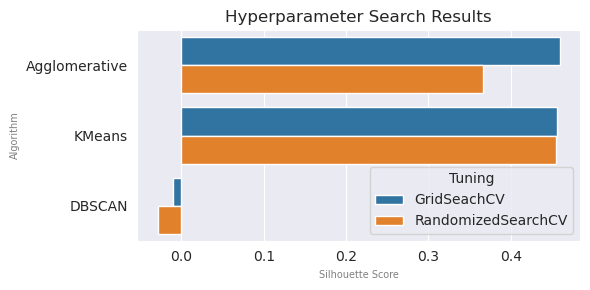

In [15]:
# Visualize tabulated results

sns.set_style('darkgrid')
plt.figure(figsize=(6,3))
hps_bar = sns.barplot(df_hps, y='Algorithm', x='Silhouette_Score', hue='Tuning')
hps_bar.set_title('Hyperparameter Search Results')
hps_bar.set_xlabel('Silhouette Score', fontsize=7, color='gray')
hps_bar.set_ylabel('Algorithm', fontsize=7, color='gray')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
Out of the model evaluation outcomes, the hyperparameters in KMeans and Agglomerative Clustering algorithm produced better silhouette scores in both cross-validation searches than DBSCAN. 

Given this result, DBSCAN may not be the appropriate clustering algorithm for this dataset since it has negative scores indicating a poor clustering performance (and more overlapping clusters) compared to the two other algorithms that have a higher score. 

</div>

**Determine the optimal KMeans hyperparameters from GridSearch, RandomizedSearch, and SMBO results**

Get SMBO best hyperparameters

In [16]:
 # Perform SMBO to get SMBO parameters. Note: X has to be scaled inside the function

time_start = time.time()
smbo=None
smbo_result = {}

trials = Trials()   

try: 
    smbo = fmin( fn = km_f_objective, 
                space = km_space,
                algo  = tpe.suggest,
                max_evals = 100, 
                trials = trials,
                rstate = np.random.default_rng(random_seed)
                )
        
    logging.info(f'[SMBO Success] {model_name} SMBO Best Parameters: {smbo}')
    print(f'SMBO {model_name} best parameters: ', smbo)

except Exception as e:
        logging.error(f'[SMBO ERROR]: {e}')

time_end = time.time()
runtime = time_end - time_start
print('Model Total running time: ', runtime)


100%|██████████| 100/100 [00:01<00:00, 54.94trial/s, best loss: -5989.735240178856]
SMBO DBSCAN best parameters:  {'algorithm': 0, 'init': 1, 'max_iter': 319.0, 'n_clusters': 2.0, 'n_init': 9.0, 'tol': 3}
Model Total running time:  1.8665077686309814


In [17]:
# Append the results to the hyperparameter search results choosing only KMeans in the dataframe
smbo_best = space_eval(km_space, smbo)
df_km_hp = df_hps[df_hps['Algorithm'] == 'KMeans'][['Tuning', 'Best_params']]
df_km_hp.loc[len(df_km_hp)] = ['SMBO', smbo_best]
df_km_hp

,Tuning,Best_params
1,GridSeachCV,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm..."
0,RandomizedSearchCV,"{'tol': 0.1, 'n_init': 5, 'n_clusters': 3, 'ma..."
2,SMBO,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm..."


Evaluate KMeans metrics for the 3 hyperparameter searches performed.

In [18]:
# Iterate through the dataframe to obtain and compare evaluation metrics
# Compute each row's metrics: Inertia and Silhouette Scores

for idx, row in df_km_hp.iterrows():
    pipeline = Pipeline(steps=[
                        ( 'scaler', StandardScaler() ),
                        ( 'kmeans', KMeans() )])
    
    pipeline.set_params(kmeans__tol = row['Best_params']['tol'], 
                        kmeans__n_init = row['Best_params']['n_init'], 
                        kmeans__n_clusters = row['Best_params']['n_clusters'], 
                        kmeans__max_iter = row['Best_params']['max_iter'],  
                        kmeans__init = row['Best_params']['init'], 
                        kmeans__algorithm = row['Best_params']['algorithm'],
                        kmeans__random_state = random_seed)
     
    pipe_km_fit = pipeline.fit(X)    
    cluster_label = pipeline.predict(X)
   
    df_km_hp.at[idx, 'Inertia'] = pipeline['kmeans'].inertia_
    df_km_hp.at[idx, 'Silhouette_Score'] = silhouette_score(X_scaled, cluster_label)

df_km_hp.sort_values('Inertia', ascending=False, inplace=True)
df_km_hp

,Tuning,Best_params,Inertia,Silhouette_Score
2,SMBO,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm...",5989.735240,0.432203
0,RandomizedSearchCV,"{'tol': 0.1, 'n_init': 5, 'n_clusters': 3, 'ma...",3521.054583,0.452974
1,GridSeachCV,"{'algorithm': 'lloyd', 'init': 'k-means++', 'm...",3517.191969,0.452665


In [19]:
# Save results to csv file
eval_fname = 'hp_compare_kmeans.csv'
eval_path = '../models/hp_tuning_results/'
eval_file = os.path.join(eval_path, eval_fname)
df_km_hp.to_csv(eval_file, index=False)

**Optimal Hyperparameter selection**

GridSearch and Random search methods are relatively inefficient compared to SMBO.\
SMBO works by considering the previously seen hyperparameter combinations when choosing the next set of hyperparameters to evluate. Grid and random searches, on the other hand, are completely uninformed by past evaluations and spends significant amount of time evaluating “bad” hyperparameters. 

SMBO is the best hyperparameter search method, so its corresponding hyperparameters will be utilized during the modeling.

In [20]:
final_best_params = df_km_hp.loc[df_km_hp.Tuning == 'SMBO','Best_params'].values[0]
final_best_params

{'algorithm': 'lloyd',
 'init': 'k-means++',
 'max_iter': 319,
 'n_clusters': 2,
 'n_init': 9,
 'tol': 0.1}

## 3 Modeling

**KMeans Modeling**

In [21]:
k_clusters = range(2,11)
cluster_labels = {}
centroids = {}
inertias = {}

for k in k_clusters:
    pipeline = Pipeline(steps=[
                        ( 'scaler', StandardScaler() ),
                        ( 'kmeans', KMeans() )])
    
    pipeline.set_params(kmeans__tol = final_best_params['tol'], 
                        kmeans__n_init = final_best_params['n_init'], 
                        kmeans__n_clusters = k, 
                        kmeans__max_iter = final_best_params['max_iter'],  
                        kmeans__init = final_best_params['init'], 
                        kmeans__algorithm = final_best_params['algorithm'],
                        kmeans__random_state = random_seed)
    
    
    pipe_km_fit = pipeline.fit(X)

    pkl_fname = "final_km_k_{}.pkl".format(k)
    pkl_path = '../models/'
    pkl_file = os.path.join( pkl_path, pkl_fname)

    joblib.dump(pipe_km_fit, pkl_file)
    
    cluster_label = pipeline.predict(X)

    #Save labels, centroids, and inertias
    cluster_labels[k] = cluster_label
    centroids[k] = pipeline['kmeans'].cluster_centers_

    inertias[k] = pipeline['kmeans'].inertia_

# Display inertias and save for metrics csv report later
eval_inertia = {}

for k in k_clusters:
    eval_inertia[k] = inertias[k]  
    print(f'n_clusters = {k} : {inertias[k]}')

n_clusters = 2 : 5989.735240178855
n_clusters = 3 : 3521.0545833873784
n_clusters = 4 : 2733.478000035656
n_clusters = 5 : 2373.5719022399717
n_clusters = 6 : 2076.1562208525397
n_clusters = 7 : 1853.703364968911
n_clusters = 8 : 1666.58194869226
n_clusters = 9 : 1525.0794463564744
n_clusters = 10 : 1430.732053089533


In [22]:
# Testing the imported pkl files (Should have the same results as above)
k_clusters = range(2,11)
pkl_path = '../models/'
pkl_inertias = {}

for k in k_clusters:
    ipkl_name = "final_km_k_{}.pkl".format(k)
    ipkl_file = os.path.join(pkl_path, ipkl_name)
    imodel = joblib.load(ipkl_file)
    imodel.fit(X)
    pkl_inertias[k] = imodel['kmeans'].inertia_

pkl_inertias

{2: 5989.735240178855,
 3: 3521.0545833873775,
 4: 2733.478000035656,
 5: 2373.5719022399717,
 6: 2076.1562208525397,
 7: 1853.7033649689115,
 8: 1666.5819486922599,
 9: 1525.0794463564744,
 10: 1430.732053089533}

Pickle file test generated the almost equal result as that of the previous step (negligible difference)  

**Determining the optimal k number of clusters**

There is no direct way to determine the optimal # of Ks from the training loss itself; loss continue to decrease for larger numbers of centers (as any given point's distance to the centers becomes lesser as they are closer). 

An Inertia Plot is useful for plotting the loss (inertia) versus the number of clusters.

**Inertia Plot: Selecting the best K- clusters**

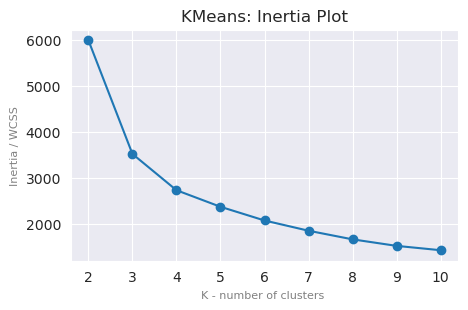

In [23]:
plt.figure(figsize=(5,3))
plt.plot(k_clusters, inertias.values(), '-o')
plt.xlabel('K - number of clusters ', fontsize=8, color='gray')
plt.ylabel('Inertia / WCSS', fontsize=8, color='gray')
plt.title('KMeans: Inertia Plot')
plt.show()

<div class="alert alert-block alert-success">
Based on the Inertia plot, the knee point is most likely at n_clusters = 3 or 4.
</div>

To further help in deciding the optimal n_clusters, the following silhouette analysis will focus on n_clusters = 2 to 5. 

**Silhouette Analysis**

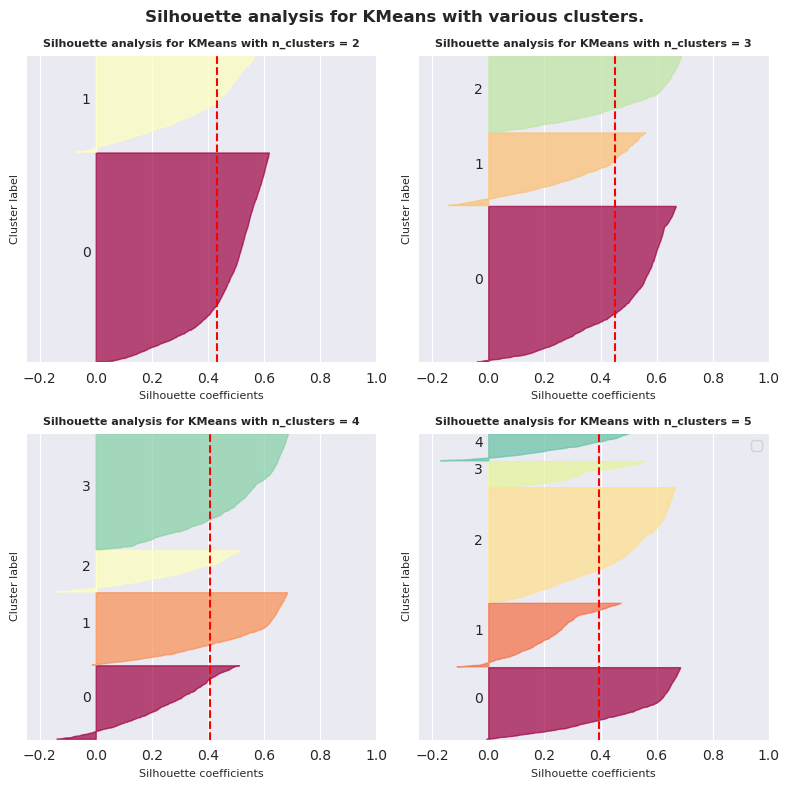

In [24]:
fig, ax1 = plt.subplots(2,2, figsize=(8,8))
avg_silhouette_scores = []
avg_per_k = {}

for i, k in enumerate(k_clusters[0:4]):

    xctr = yctr = 0
    if i%2 != 0:
        yctr = 1
    if i>=2:
        xctr = 1
    
    # The silhouette coefficient can range from -1, 1 
    ax1[xctr][yctr].set_xlim([-0.25, 1])
    ax1[xctr][yctr].set_ylim([-1, len(X) + (k + 1) * 10])

    clusterer = KMeans(n_clusters=k, 
                       random_state=random_seed, 
                       n_init = final_best_params['n_init'],
                       max_iter=final_best_params['max_iter'], 
                       init = final_best_params['init'],
                       tol = final_best_params['tol'],
                       algorithm = final_best_params['algorithm'])
    
    cl_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg  = silhouette_score(X_scaled, cl_labels)
    avg_silhouette_scores.append(silhouette_avg)
    avg_per_k[k] = silhouette_avg
    
    sample_silhouette_values = silhouette_samples(X_scaled, cl_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cl_labels == i]

        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = colormaps.get_cmap('Spectral')
        color = cmap(float(i) / k)
        ax1[xctr][yctr].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1[xctr][yctr].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

   
    ax1[xctr][yctr].set_title("Silhouette analysis for KMeans with n_clusters = %d" % k, fontsize=8, fontweight='bold')
    ax1[xctr][yctr].set_xlabel("Silhouette coefficients", fontsize=8)
    ax1[xctr][yctr].set_ylabel("Cluster label",  fontsize=8)


    ax1[xctr][yctr].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1[xctr][yctr].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[xctr][yctr].set_xticks([ -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.tight_layout()
    plt.suptitle("Silhouette analysis for KMeans with various clusters.",
                 fontsize=12, fontweight='bold')

plt.show()

<div class="alert alert-block alert-success">
Between n_clusters=3 and n_clusters=4, the former has lower negative silhouette coefficient values, and the cluster label heights is even better compared to the latter.

The optimal k number of clusters for this dataset using KMeans algorithm is 3. 
</div>

Recalculate the silhouette scores (k= 2 to 10) and combine them with the inertias retrieved earlier to the metrics .csv file

In [25]:
eval_silhouette = {}
for k in k_clusters: 
    clusterer = KMeans(n_clusters=k, 
            random_state=random_seed, 
            n_init = final_best_params['n_init'],
            max_iter=final_best_params['max_iter'], 
            init = final_best_params['init'],
            tol = final_best_params['tol'],
            algorithm = final_best_params['algorithm'])
    
    cl_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg  = silhouette_score(X_scaled, cl_labels)
    eval_silhouette[k] = round(silhouette_avg,5)

In [26]:
# Final KMeans Model Inertia Results 
df_eval_inertia = pd.DataFrame(list(eval_inertia.items()) )\
    .rename(columns = {0:'K', 1:'Inertia'})

# Final KMeans Model Silhouette scores
df_eval_silhouette = pd.DataFrame(list(eval_silhouette.items()) )\
    .rename(columns = {0:'K', 1:'Silhouette'})

# Combine Inertia and Silhouette scores
df_eval_metrics = df_eval_inertia.merge(df_eval_silhouette, on='K')

# Display result
df_eval_metrics

,K,Inertia,Silhouette
0,2,5989.735240,0.43220
1,3,3521.054583,0.45297
2,4,2733.478000,0.40850
3,5,2373.571902,0.39633
4,6,2076.156221,0.35724
5,7,1853.703365,0.33158
6,8,1666.581949,0.33343
7,9,1525.079446,0.32619
8,10,1430.732053,0.33481


In [27]:
# Save results to csv file

metrics_fname = 'km_metrics.csv'
metrics_path = '../models/model_evaluation/'
metrics_file = os.path.join(metrics_path, metrics_fname)
df_eval_metrics.to_csv(metrics_file, index=False)

## 4 Cluster Analysis

### 4.1 Cluster Distribution

In [41]:
# Create a new column, Cluster

df_clustered = df.copy(deep=True)
df_clustered['Cluster'] = cluster_labels[3]
df_clustered['Cluster'].value_counts()

Cluster
0    1882
2     913
1     879
Name: count, dtype: int64

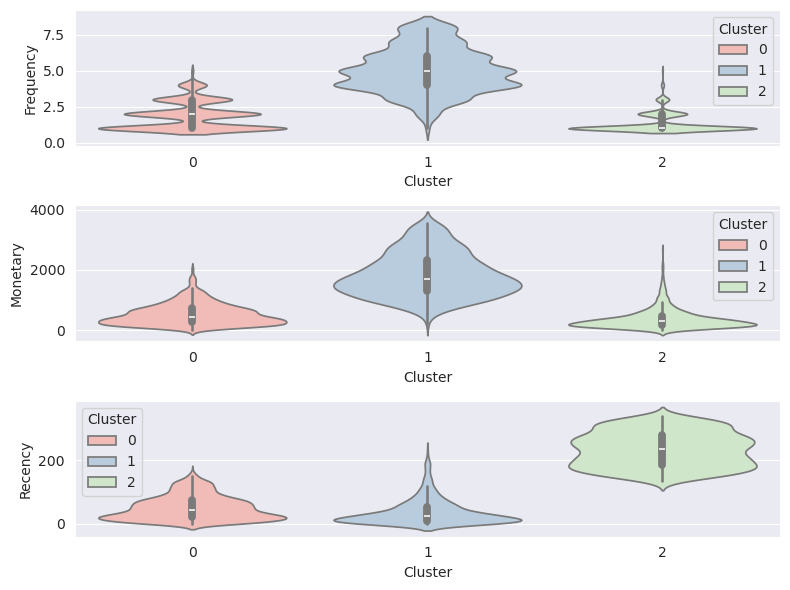

In [42]:
rfm_cols = df_clustered.columns.to_list()
rfm_cols.remove('Cluster')
rfm_cols

plt.figure(figsize=(8,6))

for idx, col in enumerate(rfm_cols):

    plt.subplot(3, 1, idx+1)
    sns.violinplot(x=df_clustered['Cluster'], y=df_clustered[col], hue=df_clustered['Cluster'], palette='Pastel1') 

plt.tight_layout()

### 4.2 Cluster Assessment

Cluster 0: **Moderate**

- Moderately frequent buyers that are not necessarily high spenders, and haven't purchased recently. 

Cluster 1: **Loyal**

- Frequent shoppers who are high spenders, although no recent purchases.

Cluster 2: **Recent**

- Less frequent buyers who are low-spenders but made recent purchases.

### 4.3 Cluster Mapping

Map the assigned customer segment labels in the previous assessment section to the cluster numbers

In [43]:
cluster_mapping = {
    0: 'Moderate', 
    1: 'Loyal',
    2: 'Recent'
}

df_clustered['Cluster'] = df_clustered.Cluster.map(cluster_mapping)
df_clustered.Cluster.value_counts()

Cluster
Moderate    1882
Recent       913
Loyal        879
Name: count, dtype: int64

## 5 Outliers Analysis

**Assigning Labels to Outliers**

In [44]:
df_m_outliers.shape[0], df_f_outliers.shape[0]

(402, 412)

Outliers will be designated as follows:
>  - Monetary outliers : High-Spenders Customers
>  - Frequency outliers : Frequent Customers
>  - Both Monetary and Frequency outliers : VIPs 

In [45]:
df_vips = df_m_outliers.merge(df_f_outliers, how='inner')
df_vips['Cluster'] = 'VIPs'

df_highsp = df_m_outliers.drop(df_vips.index)
df_highsp['Cluster'] = 'High Spenders'

df_freq = df_f_outliers.drop(df_vips.index)
df_freq['Cluster'] = 'Frequent'

df_clustered.reset_index(inplace=True)

**Combining different data and save to output file**

In [46]:
df_all = pd.concat([df_clustered, df_vips, df_highsp, df_freq])

In [47]:
# Save customer segments to file

custseg_fname = 'online_retail_customer_segments.csv'
custseg_path = '../data/processed/'
custseg_file = os.path.join(custseg_path, custseg_fname)
df_all.to_csv(custseg_file, index=False)

## 6 Customer Segmentation Visualization

Show count of each customer segments

In [48]:
df_groupings = pd.DataFrame(df_all.Cluster.value_counts())
df_groupings.reset_index(inplace=True)

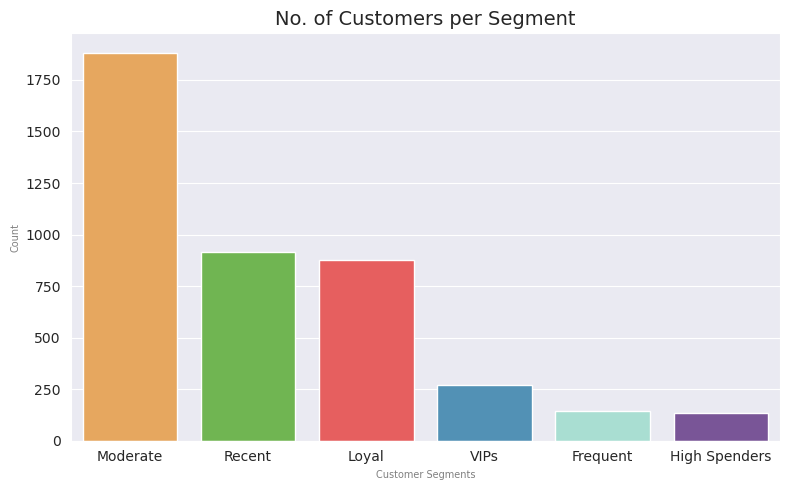

In [59]:
palette = {
                'Recent' : '#69c641',    
                'Moderate': '#fda848',   
                'Loyal':  '#fd4848' ,  
                'VIPs':   '#4196c6',
                'Frequent': '#a0e7d7',      
                'High Spenders': '#7a4aa2'       
}

sns.set_style('darkgrid')
plt.figure(figsize=(8,5))
sns.barplot( data=df_groupings, x='Cluster', y='count', palette = palette)
plt.xlabel('Customer Segments', fontsize=7, color='gray')
plt.ylabel('Count', fontsize=7, color='gray')
plt.title('No. of Customers per Segment', fontsize=14)
plt.tight_layout()
plt.show()

Show proportion of customer segments

In [50]:
df_groupings['Prop'] = round((df_groupings['count']*100)/df_groupings['count'].sum(), 2)
df_groupings

,Cluster,count,Prop
0,Moderate,1882,44.61
1,Recent,913,21.64
2,Loyal,879,20.83
3,VIPs,269,6.38
4,Frequent,143,3.39
5,High Spenders,133,3.15


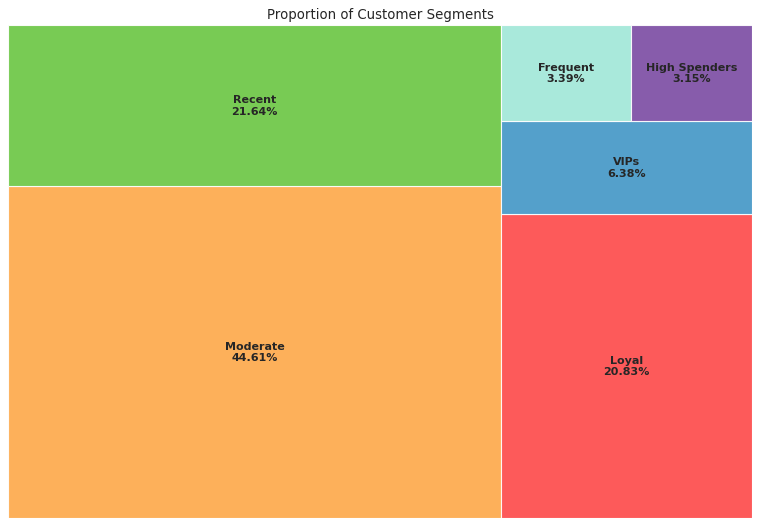

In [60]:
import squarify

sq_labels = df_groupings.apply(lambda x: str(x[0]) + "\n" + str(x[2]) + "%", axis=1)
sizes = df_groupings['count'].values.tolist()
colors = [ palette.get(c) for c in df_groupings['Cluster'].values]

plt.figure(figsize=(12,8), dpi= 80)
squarify.plot( label=sq_labels, sizes=sizes, color=colors, alpha=0.9, text_kwargs={'fontweight':'semibold'})

plt.title('Proportion of Customer Segments')
plt.axis('off')
plt.show()

## 7 Customer Segmentation Analysis and Recommendations

<font color='#fda848'><b>MODERATE</b></font>

- Moderately frequent buyers that are not necessarily high spenders, and haven't purchased recently. 

Recommendation: 
1. Offer subscription on frequently bought items (whenever applicable)
2. Recommend "Frequently bought together" items
3. Implement customer retention and loyalty programs

<font color='#69c641'><b>RECENT</b></font>


- Less frequent buyers who are low-spenders but made recent purchases.

Recommendations:
1. Identify recently purhcased products and run targeted "similar products" ad recommendations
2. Encourage to purchase more by offering incentives, vouchers, discounts, and bundle deals. 
3. Enhance customer experience and services

<font color='#fd4848'><b>LOYAL</b></font>

- Frequent shoppers who are high spenders, although no recent purchases.

Recommendations:
1. Re-engage by implementing rewards and loyalty programs, and exclusive perks
2. Run targeted ads for trending items and top items sold 
3. Offer subscription on frequently bought items (whenever applicable)

<font color='#4196c6'><b>VIPs</b></font>

- High value, frequent buyers. 

Recommendations:
1. Offer exclusive perks, and vouchers
2. Pamper and enhance shopping experience by offering expedited or free shipping (whenever applicable)

<font color='#a0e7d7'><b>FREQUENT</b></font>

- Very frequent buyers. 

Recommendations:
1. Offer subscription on frequently bought items (whenever applicable)
2. Implement customer retention and loyalty programs
3. Offer expedited or free shipping vouchers (whenever applicable)

<font color='#7a4aa2'><b>HIGH SPENDERS</b></font>

- High-spending buyers.

Recommendation: 
1. Implement customer retention and loyalty programs
2. Offer discounts on bulk purchases or reaching certain amount (whenever applicable)
3. Enhance customer experience and services